# **Body Classifier Model**

On this project, we are looking forward to building a model capable of classifying individuals among three categories, related to their perceived body type. The chosen categories were: skinny, muscular and obese. 

# Members



*   João Gabriel Araújo Vasconcelos - jgav
*   Matheus Machado Guilhermino - mmg
*   Vinícius Revoredo de Albuquerque - vra2



# **Importing fastai library**

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 38.1MB/s 
     |████████████████████████████████| 1.2MB 56.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 243kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

## Loading Azure

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'yourazurekey')

Here we create the "BodyTypes" folder and three inner folders to store the related body types.

In [ ]:
body_types = 'skinny','muscular','obese'
path = gdrive/'BodyTypes'

In [ ]:
if not path.exists():
    path.mkdir()
    for o in body_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} person')
        download_images(dest, urls=results.attrgot('contentUrl'), preserve_filename=True)

Checking content of folders

In [ ]:
fns = get_image_files(path)
fns

(#396) [Path('/content/gdrive/My Drive/BodyTypes/skinny/skinny-1024x576.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/shutterstock_244143904-750x497.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/11-habits-thin-people.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/19-habits-thin-people.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/36-habits-thin-people.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/13-habits-thin-people.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/32-habits-thin-people.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/shutterstock_303889280_resized.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/1795920_1437676518.jpg'),Path('/content/gdrive/My Drive/BodyTypes/skinny/vfy82d6cbryy.jpeg')...]

Removing corrupted images

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

Creating the datablock 

and

Dividing the images into two sets 20% for testing and 80% for training.

In [ ]:
shape = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128))

Presenting batch 

In [ ]:
dls = shape.dataloaders(path)

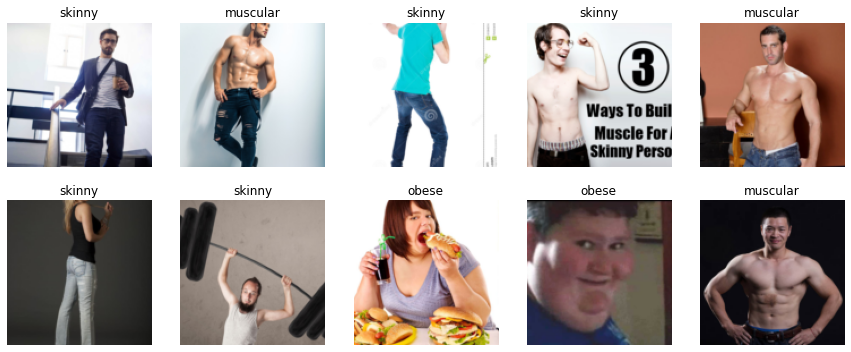

In [ ]:
dls.valid.show_batch(max_n=10, nrows=2)

## Some Resizing Methods

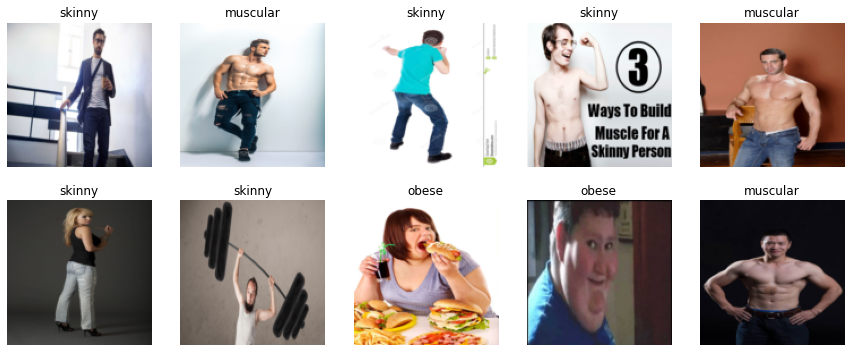

In [ ]:
shape = shape.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = shape.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=2)

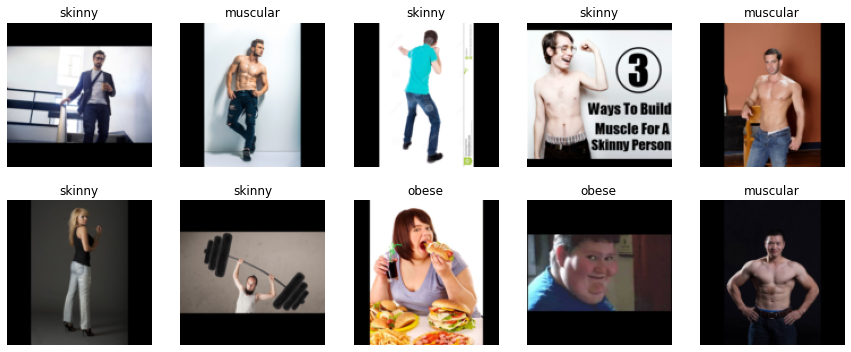

In [ ]:
shape = shape.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = shape.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=2)

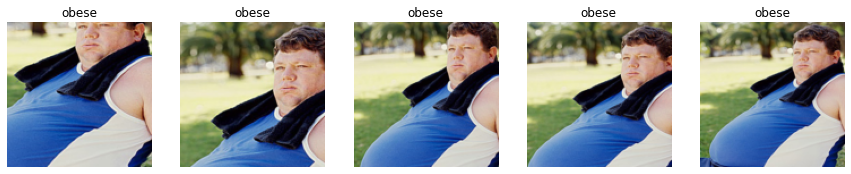

In [ ]:
shape = shape.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = shape.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

### Data Augmentation

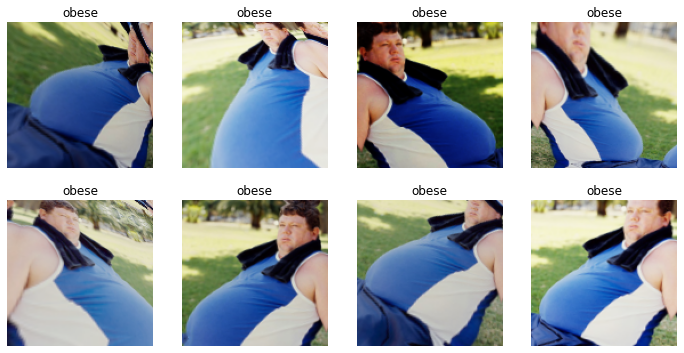

In [ ]:
shape = shape.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = shape.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the Model and Cleaning its Data

In [ ]:
shape = shape.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shape.dataloaders(path)

Here we are training our model for the first time.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


For better results we are plotting a graph to visualize the steepest point.

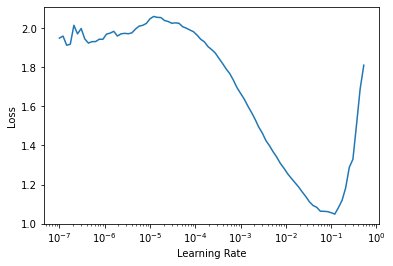

In [ ]:
lr_min,lr_steep = learn.lr_find()

Once we've gathered the value of the steepest point we get to train our model using a closer to optimal learning rate.

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 2.09e-03


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, base_lr= 2e-3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 2e-3)

Plotting the enhanced graph 

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=6.309573450380412e-07)

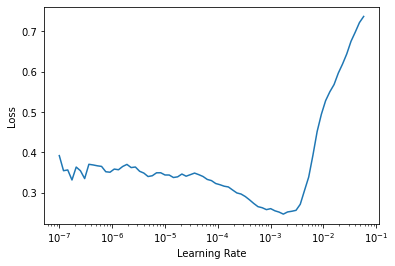

In [ ]:
learn.unfreeze()
learn.lr_find()

Analyzing the new graph to determine the maximum learning rate.

In [ ]:
learn.fit_one_cycle(6, lr_max=2e-4)

Using discriminative learning rates.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(2e-6, 8e-4))

Creating Confusion Matrix to classify the model's performance.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The five top losses.

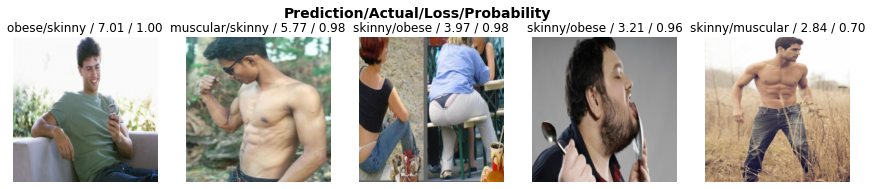

In [ ]:
interp.plot_top_losses(5, nrows=1)

Removing from our data images the 'before/after' images and images portraying food.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,error in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/error)

Retraining the model after cleaning the data.

In [ ]:
shape = shape.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shape.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(2e-6, 9e-3))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Exporting our model's results

In [ ]:
learn.export(gdrive/'export.pkl')

Checking if our export worked

In [ ]:
path = gdrive
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/My Drive/export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')


Creating a button to import an image and put our model to the test.

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: obese; Probability: 1.0000')

Finally, we create a new button to classify the image.

In [ ]:
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your body!'), 
      btn_upload, btn_run, out_pl, lbl_pred])